In [99]:
import numpy as np
rnd_gen = np.random.default_rng(2024)
import matplotlib.pyplot as plt
from scipy.integrate import quad
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from online_cp import PluginMartingale

In [100]:
wine_quality = fetch_ucirepo(id=186) 

X_test = wine_quality.data.original[wine_quality.data.original.color == 'red'].drop(columns=['quality', 'color'])
X_train = wine_quality.data.original[wine_quality.data.original.color == 'white'].drop(columns=['quality', 'color'])
y_test = wine_quality.data.original[wine_quality.data.original.color == 'red']['quality'].astype('float').values
y_train = wine_quality.data.original[wine_quality.data.original.color == 'white']['quality'].astype('float').values

X_test = ((X_test - X_test.mean()) / X_test.std()).values
X_train = ((X_train - X_train.mean()) / X_train.std()).values

# ICP online with protection
Process sequentially, and use protection

In [101]:
from sklearn.ensemble import RandomForestClassifier
from crepes import WrapClassifier

rf = RandomForestClassifier(random_state=2024)
icp = WrapClassifier(rf)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train, test_size=0.25, random_state=2024)

icp.fit(X_prop_train, y_prop_train)
icp.calibrate(X_cal, y_cal, seed=2024)

WrapClassifier(learner=RandomForestClassifier(random_state=2024), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=False))

In [102]:
icp.evaluate(X_test, y_test, confidence=0.9)

{'error': 0.13070669168230142,
 'avg_c': 2.061288305190744,
 'one_c': 0.05753595997498437,
 'empty': 0.0,
 'time_fit': 5.2928924560546875e-05,
 'time_evaluate': 0.18215036392211914}

### Run on calibration set to see the effect of change point
The calibration set is exchangeable with the training set, so we should expect to se a rather uniform betting function after processing the calibration set. This simulates a change point for the protection.

Comment out next cell to see the effect of a change point directly after training.

(0.0, 1.5)

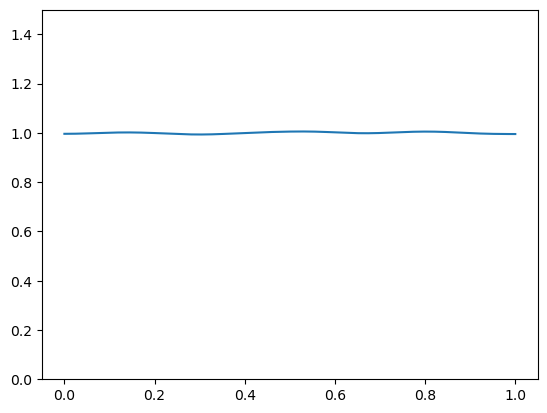

In [103]:
epsilon = 0.1
p_cal_arr = icp.predict_p(X_cal)
idx_truth = (y_cal - 3).astype('int')
true_p_cal = p_cal_arr[np.arange(p_cal_arr.shape[0]), idx_truth]

martingale = PluginMartingale(warnings=False)

for p in true_p_cal:
    martingale.update_martingale_value(p)

plt.plot(
    np.linspace(0, 1, 1000),
    martingale.b_n(np.linspace(0, 1, 1000)),
)
plt.ylim(0,1.5)

In [104]:
epsilon = 0.1
p_test_arr = icp.predict_p(X_test)
idx_truth = (y_test - 3).astype('int')
true_p_test = p_test_arr[np.arange(p_test_arr.shape[0]), idx_truth]
protected_p_arr = np.empty_like(p_test_arr)

martingale = PluginMartingale(warnings=False) # Uncomment to restart at the test set

# Since we can, we predict all p-values in a batch, but it can be done online in practice.
# It is also possible to batch update martingale, or at least betting functions.
for i, (p, unproteccted_p) in enumerate(zip(true_p_test, p_test_arr)):
    # Reality outputs test object

    # Transducer outputs p-values

    # Protector transforms p-values
    protected_p_arr[i,:] = martingale.B_n(unproteccted_p)

    # Reality outputs label

    # Update protection
    martingale.update_martingale_value(p)

In [105]:
print(f"Error rate icp: {1 - (p_test_arr > epsilon).astype('int')[np.arange(p_test_arr.shape[0]), idx_truth].mean()}")
print(f"Error rate protected icp: {1 - (protected_p_arr > epsilon).astype('int')[np.arange(protected_p_arr.shape[0]), idx_truth].mean()}")

Error rate icp: 0.13070669168230142
Error rate protected icp: 0.09380863039399623


In [106]:
print(f'Average set size icp: {(p_test_arr > epsilon).mean(axis=0).sum()}')
print(f'Average set size protected icp: {(protected_p_arr > epsilon).mean(axis=0).sum()}')

Average set size icp: 2.0612883051907445
Average set size protected icp: 2.3402126328955597


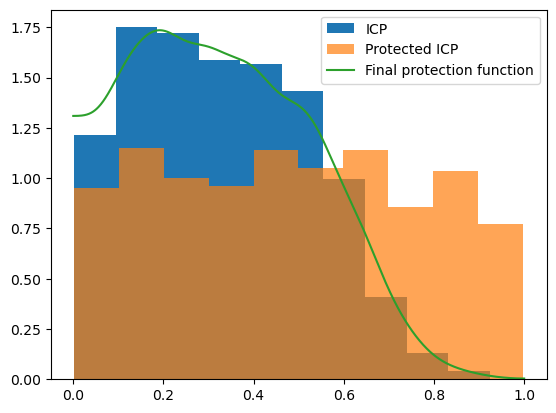

In [107]:
p_test_protected = protected_p_arr[np.arange(protected_p_arr.shape[0]), idx_truth]

plt.hist(true_p_test, label='ICP', density=True)
plt.hist(p_test_protected, label='Protected ICP', density=True, alpha=0.7)
plt.plot(
    np.linspace(0, 1, 1000),
    martingale.b_n(np.linspace(0, 1, 1000)),
    label='Final protection function'
)
plt.legend()

# Idea to tackle poor density estimates
Nothing says that we have to take into account all historical p-values when we estimate density. It is still a betting function if we are selective. Perhaps we could estimate density on a rolling window or something like that? 

Basically, we could have a window_size $W$ for the kernel density, and use only the last $W$ p-values to estimate the density. 

# Regression
How do we apply protection here?

In [108]:
# # fetch dataset Concrete Compressive Strength
# concrete_compressive_strength = fetch_ucirepo(id=165) 
  
# # data (as pandas dataframes) 
# X = concrete_compressive_strength.data.features.astype('float').values
# Y = concrete_compressive_strength.data.targets.astype('float').values.flatten()

# X = (X - X.mean()) / X.std()

# # # Ensure all labels are unique
# # noise_range = 1e-6
# # while np.unique(Y).shape[0] < Y.shape[0]:
# #     # Find duplicates
# #     unique, counts = np.unique(Y, return_counts=True)
# #     duplicates = unique[counts > 1]

# #     # Add noise to duplicate entries
# #     for label in duplicates:
# #         indices = np.where(Y == label)[0]
# #         noise = rnd_gen.uniform(low=-noise_range, high=noise_range, size=len(indices))
# #         Y[indices] += noise

# initial_training_size = 100
# X_train = X[:initial_training_size]
# y_train = Y[:initial_training_size]
# X_test = X[initial_training_size:]
# y_test = Y[initial_training_size:]

In [109]:
from sklearn.ensemble import RandomForestRegressor
from crepes import WrapRegressor

rf = RandomForestRegressor(random_state=2024)
icp = WrapRegressor(rf)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train, test_size=0.25, random_state=2024)

icp.fit(X_prop_train, y_prop_train)
icp.calibrate(X_cal, y_cal, seed=2024)

WrapRegressor(learner=RandomForestRegressor(random_state=2024), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=False, mondrian=False))

In [110]:
icp.evaluate(X_test, y_test, confidence=0.9)

{'error': 0.13383364602876802,
 'eff_mean': 2.1199999999999988,
 'eff_med': 2.119999999999999,
 'time_fit': 5.507469177246094e-05,
 'time_evaluate': 0.0002484321594238281}

Crepes uses absolute residuals in this simple case

In [111]:
base_pred = icp.predict_int(X_test)

In [112]:
Alpha = icp.cr.alphas

rnd_gen = np.random.default_rng(2024)
Alpha_pred = (np.abs(icp.predict(X_test) - y_test))
p_values = np.empty_like(Alpha_pred)
for i, alpha in enumerate(Alpha_pred):
    p = ((Alpha > alpha).sum() + rnd_gen.uniform(0,1)*(Alpha == alpha).sum() + 1) / (Alpha.shape[0]+1)
    p_values[i] = p

In [113]:
# Compute the random contribution for ties (Alpha == Alpha_pred)
rnd_gen = np.random.default_rng(2024)

Tau = rnd_gen.uniform(0, 1, Alpha_pred.shape)

# Compare Alpha with Alpha_pred to count occurrences
greater_counts = (Alpha[:, None] > Alpha_pred).sum(axis=0)  # Count Alpha > Alpha_pred
equal_counts = (Alpha[:, None] == Alpha_pred).sum(axis=0)  # Count Alpha == Alpha_pred

# Compute p-values vectorized
p_values = (greater_counts + Tau * equal_counts + 1) / (Alpha.shape[0] + 1)

In [114]:
martingale = PluginMartingale(warnings=False) # Uncomment to restart at the test set

protected_p_values = np.empty_like(p_values)
# Since we can, we predict all p-values in a batch, but it can be done online in practice.
# It is also possible to batch update martingale, or at least betting functions.
for i, p in enumerate(p_values):
    # Reality outputs test object

    # Transducer outputs p-values

    # Protector transforms p-values
    protected_p_values[i] = martingale.B_n(p)

    # Reality outputs label

    # Update protection
    martingale.update_martingale_value(p)

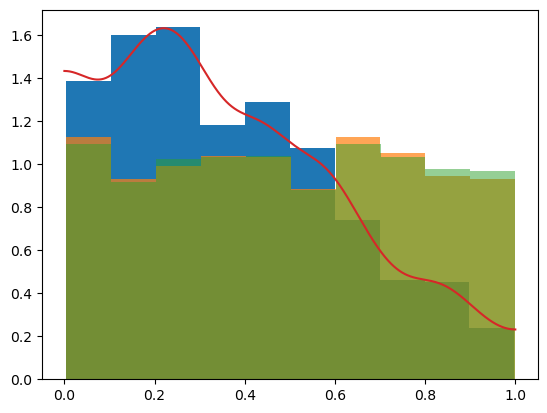

In [115]:
plt.hist(p_values, density=True)
plt.hist(protected_p_values, density=True, alpha=0.7)
plt.hist(martingale.B_n(p_values), density=True, alpha=0.5)
plt.plot(
    np.linspace(0, 1, 1000),
    martingale.b_n(np.linspace(0, 1, 1000)),
    label='Final protection function'
)

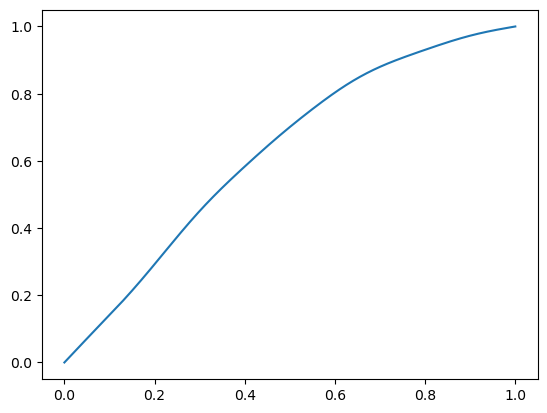

In [116]:
plt.plot(
    np.linspace(0, 1, 1000),
    martingale.B_n(np.linspace(0, 1, 1000)),
    label='Final protection function'
)

In [117]:
from scipy.optimize import fsolve

epsilon = 0.1

base_pred = icp.predict_int(X_test, confidence=1-epsilon)

protected_pred = np.empty_like(base_pred)

martingale = PluginMartingale(warnings=False) # Uncomment to restart at the test set

protected_p_values = np.empty_like(p_values)

for i, p in enumerate(p_values):
    # Reality outputs test object

    # Protected significance level
    func = lambda x: martingale.B_n(x) - epsilon
    epsilon_hat = fsolve(func, epsilon)[0]

    # Protector transforms p-values
    protected_pred[i,:] = icp.predict_int(X_test[i].reshape(1,-1), confidence=1-epsilon_hat)
    # Reality outputs label

    # Update protection
    martingale.update_martingale_value(p)

In [118]:
ind_protected_pred = icp.predict_int(X_test, confidence=1-epsilon_hat)

In [119]:
((base_pred[:,0] > y_test).astype(int) + (base_pred[:,1] < y_test).astype(int)).mean()

0.133833646028768

In [120]:
((protected_pred[:,0] > y_test).astype(int) + (protected_pred[:,1] < y_test).astype(int)).mean()

0.10756722951844903

In [121]:
((ind_protected_pred[:,0] > y_test).astype(int) + (ind_protected_pred[:,1] < y_test).astype(int)).mean()

0.10131332082551595

In [122]:
np.abs((base_pred[:,0] - base_pred[:,1])).mean()

2.1199999999999988

In [123]:
np.abs((protected_pred[:,0] - protected_pred[:,1])).mean()

2.320700437773609

In [124]:
np.abs((ind_protected_pred[:,0] - ind_protected_pred[:,1])).mean()

2.3800000000000012

# ICP protection

This is all rubbish! We can not know the p-values unless we have the true labels. ICP can indeed be protected, but only online or in a "batch protection" setting.

In [125]:
import numpy as np
rnd_gen = np.random.default_rng(2024)
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from online_cp import PluginMartingale
from scipy.optimize import brentq

def quantile(p, cdf_func):
# Invert CDF using root-finding (find x such that cdf(x) = p)
    return brentq(lambda x: cdf_func(x) - p, 0, 1)

In [143]:
change_point = False

wine_quality = fetch_ucirepo(id=186) 

wine = wine_quality.data.original

if change_point:
    X_test = wine_quality.data.original[wine_quality.data.original.color == 'red'].drop(columns=['quality', 'color'])
    X_train = wine_quality.data.original[wine_quality.data.original.color == 'white'].drop(columns=['quality', 'color'])
    y_test = wine_quality.data.original[wine_quality.data.original.color == 'red']['quality'].astype('float').values
    y_train = wine_quality.data.original[wine_quality.data.original.color == 'white']['quality'].astype('float').values

    X_test = ((X_test - X_test.mean()) / X_test.std()).values
    X_train = ((X_train - X_train.mean()) / X_train.std()).values

else:
    X = wine.drop(columns=['quality', 'color']).values
    Y = wine['quality'].astype('float').values

    X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    N = int(X.shape[0]/2)
    X_train = X[:N]
    y_train = Y[:N]
    X_test=X[N:]
    y_test=Y[N:]

In [127]:
# # fetch dataset Concrete Compressive Strength
# concrete_compressive_strength = fetch_ucirepo(id=165) 
  
# # data (as pandas dataframes) 
# X = concrete_compressive_strength.data.features.astype('float').values
# Y = concrete_compressive_strength.data.targets.astype('float').values.flatten()

# X = (X - X.mean()) / X.std()

# # Ensure all labels are unique
# noise_range = 1e-6
# while np.unique(Y).shape[0] < Y.shape[0]:
#     # Find duplicates
#     unique, counts = np.unique(Y, return_counts=True)
#     duplicates = unique[counts > 1]

#     # Add noise to duplicate entries
#     for label in duplicates:
#         indices = np.where(Y == label)[0]
#         noise = rnd_gen.uniform(low=-noise_range, high=noise_range, size=len(indices))
#         Y[indices] += noise

# initial_training_size = 500
# X_train = X[:initial_training_size]
# y_train = Y[:initial_training_size]
# X_test = X[initial_training_size:]
# y_test = Y[initial_training_size:]

## Classification

/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/martingale.py:95: RuntimeWarning: overflow encountered in exp
  return np.exp(self.logM)


Base error rate icp: 0.12526931363496463
Protected error rate icp: 0.10557094490612495

Base OF: 1627.1501727032926
Protected OF: 2283.4545094899822

Base OE: 4436
Protected OE: 4864


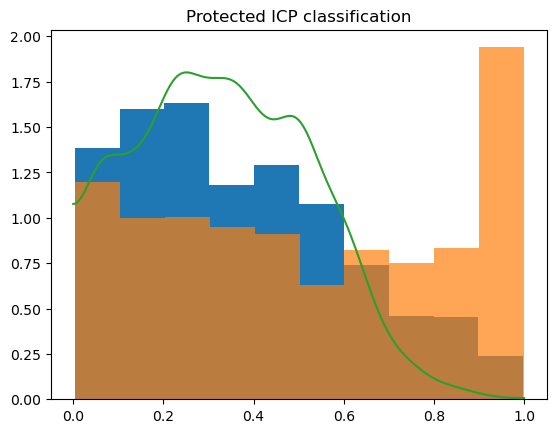

In [128]:
from sklearn.ensemble import RandomForestClassifier
from crepes import WrapClassifier


def compute_OE(pred, y_test):
    'Custom for wine dataset...'
    OE = 0
    for i, Gamma in enumerate(pred):
        if Gamma[int(y_test[i]-3)] == 1:
            OE += Gamma.sum()-1
        else:
            OE += Gamma.sum()
    return OE

rf = RandomForestClassifier(random_state=2024)
icp = WrapClassifier(rf)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train, test_size=0.25, random_state=2024)

icp.fit(X_prop_train, y_prop_train)
icp.calibrate(X_cal, y_cal, seed=2024)

epsilon = 0.1
p_test_arr = icp.predict_p(X_test)
idx_truth = (y_test - 3).astype('int')

# Since we can, we predict all p-values in a batch
p_test = p_test_arr[np.arange(p_test_arr.shape[0]), idx_truth]

martingale = PluginMartingale(warnings=False)
# In principle, we can batch update the betting function as well.

for i, p in enumerate(p_test):
    # Update protection
    martingale.update_martingale_value(p)

protected_p_values = martingale.B_n(p_values)
plt.hist(p_values, density=True)
plt.hist(protected_p_values, density=True, alpha=0.7)
plt.plot(
    np.linspace(0, 1, 1000),
    martingale.b_n(np.linspace(0, 1, 1000)),
    label='Final protection function'
)
plt.title('Protected ICP classification')

base_pred = icp.predict_set(X_test, confidence=1-epsilon)

# Protected significance level
func = lambda x: martingale.B_n(x) - epsilon
epsilon_hat = brentq(func, 0, 1)

protected_pred = icp.predict_set(X_test, confidence=1-epsilon_hat)

p_test_protected = martingale.B_n(p_test)
p_test_protected_arr = np.empty_like(p_test_arr)
for j in range(p_test_arr.shape[1]):
    p_test_protected_arr[:,j] = martingale.B_n(p_test_arr[:,j])

print(f"Base error rate icp: {1 - (p_test_arr > epsilon).astype('int')[np.arange(p_test_arr.shape[0]), idx_truth].mean()}")
print(f"Protected error rate icp: {1 - (p_test_protected_arr > epsilon).astype('int')[np.arange(p_test_protected_arr.shape[0]), idx_truth].mean()}")
print()

print(f'Base OF: {p_test_arr.sum() - p_test.sum()}')
print(f'Protected OF: {p_test_protected_arr.sum() - p_test_protected.sum()}')

print()

print(f'Base OE: {compute_OE(base_pred, y_test)}')
print(f'Protected OE: {compute_OE(protected_pred, y_test)}')

In [129]:
(p_test <= epsilon_hat).mean(), (p_test_protected <= epsilon).mean()

(0.10557094490612497, 0.10557094490612497)

Text(0.5, 1.0, 'Protection function classification')

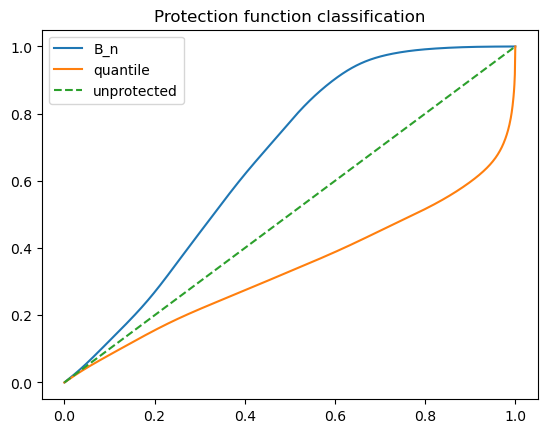

In [130]:
plt.plot(
    np.linspace(0, 1, 1000),
    martingale.B_n(np.linspace(0, 1, 1000)),
    label='B_n'
)
plt.plot(
    np.linspace(0, 1, 1000),
    [quantile(p, martingale.B_n) for p in np.linspace(0, 1, 1000)],
    label='quantile'
)
plt.plot(
    np.linspace(0, 1, 1000),
    np.linspace(0, 1, 1000),
    linestyle='--',
    label='unprotected'
)
plt.legend()
plt.title('Protection function classification')

## Regression

Below is rubbish! We can not get the p-values until we have the true labels.

Base error rate icp: 0.08033240997229917
Protected error rate icp: 0.08033240997229917

Base width: 2.6799999999999997
Protected width: 2.6799999999999997

Base winkler score: 10880.52
Protected winkler score: 10880.52


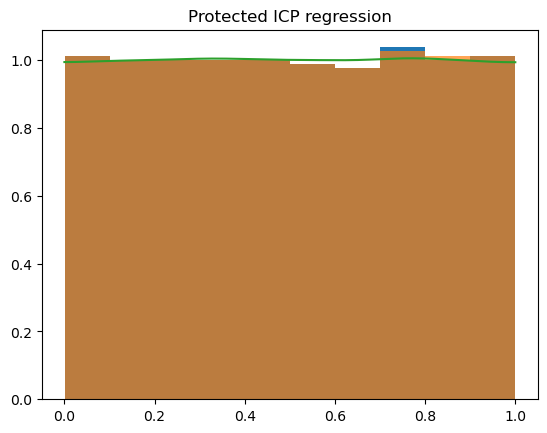

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from crepes import WrapRegressor

def winkler(intervals, true_values, alpha):
    # Define intervals and true values
    L = intervals[:, 0]  # Lower bounds
    U = intervals[:, 1]  # Upper bounds
    y = true_values      # True values

    # Compute components of Winkler score
    width = U - L  # Interval width
    below = L - y  # Difference when true value is below L
    above = y - U  # Difference when true value is above U

    # Compute Winkler score for each case
    winkler_score = np.where(
        y < L,  # Case 1: y < L
        width + (2 / alpha) * below,
        np.where(
            y > U,  # Case 3: y > U
            width + (2 / alpha) * above,
            width  # Case 2: L <= y <= U
        )
    )
    return winkler_score

rf = RandomForestRegressor(random_state=2024)
icp = WrapRegressor(rf)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train, test_size=0.25, random_state=2024)

icp.fit(X_prop_train, y_prop_train)
icp.calibrate(X_cal, y_cal, seed=2024)

rnd_gen = np.random.default_rng(2024)

Alpha = icp.cr.alphas

Tau = rnd_gen.uniform(0, 1, Alpha.shape)

greater_counts = (Alpha[:, None] > Alpha).sum(axis=0) 
equal_counts = (Alpha[:, None] == Alpha).sum(axis=0)  

# Compute p-values vectorized
p_values = (greater_counts + Tau * equal_counts + 1) / (Alpha.shape[0] + 1)

# Base prediction
base_pred = icp.predict_int(X_test, confidence=1-epsilon)

martingale = PluginMartingale(warnings=False) 

for i, p in enumerate(p_values):
    # Update protection
    martingale.update_martingale_value(p)

protected_p_values = martingale.B_n(p_values)
plt.hist(p_values, density=True)
plt.hist(protected_p_values, density=True, alpha=0.7)
plt.plot(
    np.linspace(0, 1, 1000),
    martingale.b_n(np.linspace(0, 1, 1000)),
    label='Final protection function'
)
plt.title('Protected ICP regression')

# Protected significance level
func = lambda x: martingale.B_n(x) - epsilon
epsilon_hat = brentq(func, 0, 1)

protected_pred = icp.predict_int(X_test, confidence=1-epsilon_hat)

print(f"Base error rate icp: {((base_pred[:,0] > y_test).astype(int) + (base_pred[:,1] < y_test).astype(int)).mean()}")
print(f"Protected error rate icp: {((protected_pred[:,0] > y_test).astype(int) + (protected_pred[:,1] < y_test).astype(int)).mean()}")

print()

print(f'Base width: {(base_pred[:,1] - base_pred[:,0]).mean()}')
print(f'Protected width: {(protected_pred[:,1] - protected_pred[:,0]).mean()}')

print()

print(f'Base winkler score: {winkler(base_pred, y_test, epsilon).sum()}')
print(f'Protected winkler score: {winkler(protected_pred, y_test, epsilon).sum()}')

In [140]:
# The deviation from the error rate computed from predictiton sets may be down to smoothing...
(p_values <= epsilon_hat).mean(), (protected_p_values <= epsilon).mean()

(0.09852216748768473, 0.09852216748768473)

Text(0.5, 1.0, 'Protection function regression')

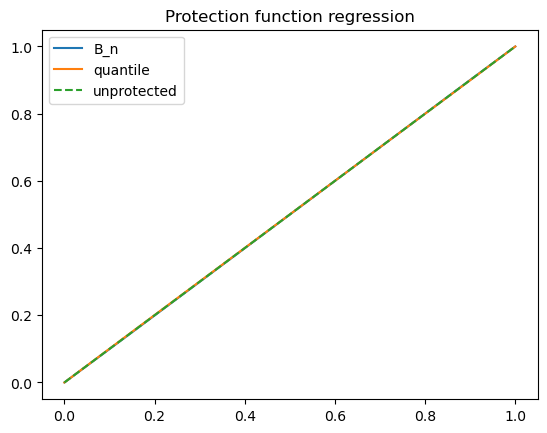

In [141]:
plt.plot(
    np.linspace(0, 1, 1000),
    martingale.B_n(np.linspace(0, 1, 1000)),
    label='B_n'
)
plt.plot(
    np.linspace(0, 1, 1000),
    [quantile(p, martingale.B_n) for p in np.linspace(0, 1, 1000)],
    label='quantile'
)
plt.plot(
    np.linspace(0, 1, 1000),
    np.linspace(0, 1, 1000),
    linestyle='--',
    label='unprotected'
)
plt.legend()
plt.title('Protection function regression')